In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as st
from scipy.stats import multivariate_normal

from torch.autograd import Variable
from utls import *
from torchsummary import *

torch.cuda.set_device('cuda:1')
#torch.set_default_tensor_type('torch.cuda.FloatTensor')
device=torch.device('cuda:1')

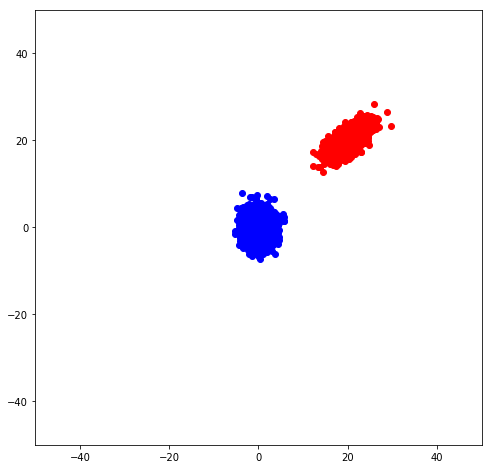

In [2]:
# Dataset

X_train1 = np.random.multivariate_normal([0, 0], [[3, 0], [0, 5]], 2000)
X_train2 = np.random.multivariate_normal([20, 20], [[5, 3], [3, 4]], 2000)
Y1 = 0 * np.ones(2000)
Y2 = 1 * np.ones(2000)

X_in = np.concatenate([X_train1, X_train2])
Y_in = np.concatenate([Y1, Y2])
Y = np.zeros(4000)
Y_in = np.column_stack((Y_in, Y))
plt.figure(figsize=[8,8])
plt.ylim(-50, 50)
plt.xlim(-50, 50)
plt.scatter(X_train1[:,0], X_train1[:,1], c='b')
plt.scatter(X_train2[:,0], X_train2[:,1], c='r')

In [3]:
def p(x):
    return multivariate_normal.pdf(x, mean=[0, 0], cov=[[3, 0], [0, 5]]) + multivariate_normal.pdf(x, mean=[20, 20], cov=[[5, 3], [3, 4]])

def q(x, low=-50, high=50):
    return 1./((high - low)**2)

# x = np.arange(-50, 50)
# k = max(p(x) / q(x))


def rejection_sampling(N=200, low=[-50, -50], high=[50, 50]):
    samples = []

    for i in range(1000):
        z = np.random.uniform(low=low, high=high, size=(1,2))
        u = q(z, low=low[0], high=high[0])

        if u >= 0.8*p(z):
            samples.append(z[0])
        if(len(samples) >= N):
            break

    return np.array(samples)

## Case 1: The out-of-distribution data generate by rejection sampling on the entire space [-50, 50]

## Case 2: The out-of-distribution data generate by rejection sampling on the entire space [-20, 20]

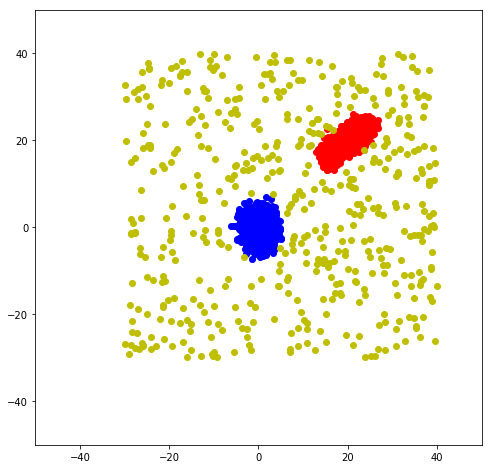

In [4]:
X_out = rejection_sampling(N=500, low=[-30, -30], high=[40, 40])
Y_out = np.ones((500, 2))

plt.figure(figsize=[8,8])
plt.ylim(-50, 50)
plt.xlim(-50, 50)
plt.scatter(X_train1[:,0], X_train1[:,1], c='b')
plt.scatter(X_train2[:,0], X_train2[:,1], c='r')
plt.scatter(X_out[:,0], X_out[:,1], c='y')
plt.show()

In [5]:
X_test = np.random.uniform(low=[-50, -50], high=[50, 50], size=(5000,2))
Y_test = 0 * np.ones((5000, 2))

### objective = E_pin(x,y)[-log P(y|x)] + BE_pout(x)[KL(U(y)||P(y|x))]

In [6]:
class dataload(TensorDataset):
    """Customized dataset loader"""
    def __init__(self, mode):

        if(mode == 'test'):
            self.data = X_test
            self.labels = Y_test
        else:
            self.data = np.concatenate([X_in, X_out])
            self.labels = np.concatenate([Y_in, Y_out])
        self.labels = self.labels.astype(np.long)

    def __len__(self):
        return (self.data.shape[0])

    def __getitem__(self, idx):
        data = self.data[idx]
        labels = self.labels[idx]
        return data, labels

In [7]:
Train_data = dataload(mode = 'train')
Train_dataloader = DataLoader(dataset=Train_data, batch_size = 100, shuffle=True)


In [8]:
class twohiddenNet(nn.Module):
    def __init__(self, num_classes = 2):
        super(twohiddenNet, self).__init__()
        self.layers = nn.Sequential(
            nn.Linear(2, 500),
            nn.ReLU(),
            nn.Linear(500, 500),
            nn.ReLU(),
            nn.Linear(500, 2),
        )
    def forward(self, x):
        out = self.layers(x)
        return out

In [9]:
class cross_entropy(nn.Module):
    def __init__(self, num_classes):
        super(cross_entropy, self).__init__()
        self.num_classes = num_classes
        self.beta = 1
        self.in_dist_loss = nn.NLLLoss(reduction='none')
        
    def forward(self, output, target):
        class_target = target[:, 0]
        in_target = target[:, 1].float()
        output = F.log_softmax(output, dim=1)
        
        in_dist = self.in_dist_loss(output, class_target)
        in_dist =  (1 - in_target) * in_dist
        
        return in_dist.mean()

class confidence_Loss(nn.Module):
    def __init__(self, num_classes):
        super(confidence_Loss, self).__init__()
        self.num_classes = num_classes
        self.beta = 1
        self.in_dist_loss = nn.NLLLoss(reduction='none')
        self.out_dist_loss = nn.KLDivLoss(reduction='none')
        
    def forward(self, output, target):
        class_target = target[:, 0]
        in_target = target[:, 1].float()
        uniform_dist = torch.Tensor(output.size(0), self.num_classes).fill_((1./self.num_classes)).cuda()
        output = F.log_softmax(output, dim=-1)
        in_dist = self.in_dist_loss(output, class_target)
        in_dist = (1 - in_target) * in_dist
        out_dist = self.out_dist_loss(output, uniform_dist)
        out_dist = out_dist.sum(dim=-1)
        out_dist = out_dist * (in_target)
        
        return in_dist.mean() + self.beta * out_dist.mean()

In [10]:
from torchsummary import summary
data,_ = next(iter(Train_dataloader))

_model = twohiddenNet(num_classes = 2)
_model = _model.to(device)
summary(_model, input_size= data[0].size())

criterion = confidence_Loss(num_classes = 2)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1                  [-1, 500]           1,500
              ReLU-2                  [-1, 500]               0
            Linear-3                  [-1, 500]         250,500
              ReLU-4                  [-1, 500]               0
            Linear-5                    [-1, 2]           1,002
Total params: 253,002
Trainable params: 253,002
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.02
Params size (MB): 0.97
Estimated Total Size (MB): 0.98
----------------------------------------------------------------


In [11]:
from tqdm import tqdm_notebook as tqdm
optimizer = torch.optim.Adam(_model.parameters(), lr=0.01)
epoches = 100
for epoch in range(1, epoches + 1):
    print("[%d/%d]"%(epoch, epoches))
    ######Training#######
    _model.train()
    for data, classes in tqdm(Train_dataloader):
        labels = classes.cuda()
        data = data.cuda().float()

        optimizer.zero_grad()
        a = _model(data)
        loss = criterion(output=a, target=labels)
        loss.backward()
        optimizer.step()
        
        p_class = F.softmax(a, dim=1)
            
    print("train loss: ", loss.item())
                
torch.save(_model.state_dict(), 'logs/_pre_init.pt')

    
   

[1/100]



train loss:  0.18800559639930725
[2/100]



train loss:  0.12059464305639267
[3/100]



train loss:  0.04221866652369499
[4/100]



train loss:  0.04332772642374039
[5/100]



train loss:  0.019133079797029495
[6/100]



train loss:  0.023876305669546127
[7/100]



train loss:  0.006795505061745644
[8/100]



train loss:  0.006034540943801403
[9/100]



train loss:  0.04734751582145691
[10/100]



train loss:  0.0009577319142408669
[11/100]



train loss:  0.05195644497871399
[12/100]



train loss:  0.0028856219723820686
[13/100]



train loss:  0.02878912165760994
[14/100]



train loss:  0.058567602187395096
[15/100]



train loss:  0.04244323819875717
[16/100]



train loss:  0.006225185003131628
[17/100]



train loss:  0.04291403293609619
[18/100]



train loss:  0.009600345976650715
[19/100]



train loss:  0.04079115018248558
[20/100]



train loss:  0.0030262928921729326
[21/100]



train loss:  0.0318935289978981
[22/100]



train loss:  0.0012292900355532765
[23/100]



train loss:  0.0014200195437297225
[24/100]



train loss:  0.016743307933211327
[25/100]



train loss:  0.0004798751906491816
[26/100]



train loss:  0.02821328304708004
[27/100]



train loss:  0.0019685891456902027
[28/100]



train loss:  0.0074744075536727905
[29/100]



train loss:  0.017910704016685486
[30/100]



train loss:  0.03301803395152092
[31/100]



train loss:  0.02827487140893936
[32/100]



train loss:  0.0050290548242628574
[33/100]



train loss:  0.006670666858553886
[34/100]



train loss:  0.004026451148092747
[35/100]



train loss:  0.0020908289588987827
[36/100]



train loss:  0.004290333483368158
[37/100]



train loss:  0.0003160092164762318
[38/100]



train loss:  0.0007141059031710029
[39/100]



train loss:  0.0011639887234196067
[40/100]



train loss:  0.010516135953366756
[41/100]



train loss:  0.007093531545251608
[42/100]



train loss:  0.004505680873990059
[43/100]



train loss:  1.5181600247160532e-05
[44/100]



train loss:  0.006890556309372187
[45/100]



train loss:  0.035917848348617554
[46/100]



train loss:  0.006424293387681246
[47/100]



train loss:  0.01775987446308136
[48/100]



train loss:  0.05161399021744728
[49/100]



train loss:  0.005606226623058319
[50/100]



train loss:  0.0032837833277881145
[51/100]



train loss:  0.028208507224917412
[52/100]



train loss:  0.013151928782463074
[53/100]



train loss:  0.005843210965394974
[54/100]



train loss:  0.0001832696725614369
[55/100]



train loss:  0.0015446771867573261
[56/100]



train loss:  0.0245045255869627
[57/100]



train loss:  0.01720176264643669
[58/100]



train loss:  0.00011216848361073062
[59/100]



train loss:  0.0010063027730211616
[60/100]



train loss:  0.0003946772194467485
[61/100]



train loss:  0.04287172853946686
[62/100]



train loss:  0.003849801141768694
[63/100]



train loss:  0.019770938903093338
[64/100]



train loss:  0.0027586279902607203
[65/100]



train loss:  0.000726937607396394
[66/100]



train loss:  0.0011116795940324664
[67/100]



train loss:  0.0005540084675885737
[68/100]



train loss:  0.0034339954145252705
[69/100]



train loss:  0.0003574240254238248
[70/100]



train loss:  4.346519926912151e-05
[71/100]



train loss:  0.02014404907822609
[72/100]



train loss:  0.0001915410248329863
[73/100]



train loss:  0.003343846183270216
[74/100]



train loss:  0.0003546836960595101
[75/100]



train loss:  0.0015680192736908793
[76/100]



train loss:  0.0038951660972088575
[77/100]



train loss:  0.0007185611175373197
[78/100]



train loss:  0.0029904665425419807
[79/100]



train loss:  2.8588472559931688e-05
[80/100]



train loss:  0.00012985378270968795
[81/100]



train loss:  0.0085195517167449
[82/100]



train loss:  0.0012977173319086432
[83/100]



train loss:  0.007057104259729385
[84/100]



train loss:  0.000272057339316234
[85/100]



train loss:  0.0017335705924779177
[86/100]



train loss:  0.004828052595257759
[87/100]



train loss:  0.0048879096284508705
[88/100]



train loss:  0.010180564597249031
[89/100]



train loss:  0.010305957868695259
[90/100]



train loss:  0.0038251327350735664
[91/100]



train loss:  0.0002082496794173494
[92/100]



train loss:  0.001847773208282888
[93/100]



train loss:  0.0014955556252971292
[94/100]



train loss:  0.0011393361492082477
[95/100]



train loss:  0.014428442344069481
[96/100]



train loss:  0.02945173904299736
[97/100]



train loss:  0.007922669872641563
[98/100]



train loss:  0.00229091988876462
[99/100]



train loss:  0.01616998389363289
[100/100]



train loss:  0.008418027311563492


In [12]:
Test_data = dataload(mode = 'test')
Test_dataloader = DataLoader(dataset=Test_data, batch_size = 5000, shuffle=False)
print(Test_data.__len__())

_model.eval()   
with torch.no_grad():
    for data, classes in (Test_dataloader):

        labels = classes.cuda()
        data = data.cuda().float()
        a = _model(data)
        # loss = criterion(output=a, target=labels, r = margin)
        loss = criterion(output=a, target=labels)

        p_class = F.softmax(a, dim=1)
    print(p_class)

5000
tensor([[0.4980, 0.5020],
        [0.0344, 0.9656],
        [0.4980, 0.5020],
        ...,
        [0.4980, 0.5020],
        [0.4980, 0.5020],
        [0.4980, 0.5020]], device='cuda:0')


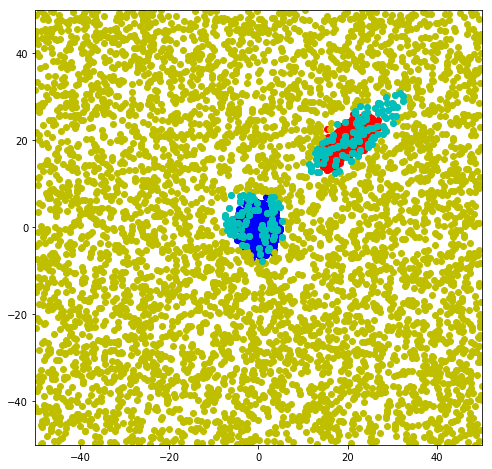

In [13]:
p = np.max(p_class.cpu().numpy(), axis=1)
X_highpro = X_test[p > 0.8]

plt.figure(figsize=[8,8])
plt.ylim(-50, 50)
plt.xlim(-50, 50)
plt.scatter(X_train1[:,0], X_train1[:,1], c='b')
plt.scatter(X_train2[:,0], X_train2[:,1], c='r')
plt.scatter(X_test[:,0], X_test[:,1], c='y')
plt.scatter(X_highpro[:,0], X_highpro[:,1], c='c')
plt.show()
